## This example presents a simple univariate time series prediction problem.

We are predicting the next day's Amazon's stock.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Read the amazon stock historical data. We will be using the column 'Close' for predicting the next day's close price.

In [3]:
amzn = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/AMZN.csv",date_format=True)

In [4]:
amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Data preprocessing for LSTM

1. Apply a scaler to the stock price to squash its value.
2. Define a past datestamp `n_past_steps`, i.e. how many days you want to look back for predicting the next day. Can be a hyperparameter to tune.
3. create a sequence of the data, this will eseentially create `n_past_steps` new columns shifted by 1 day, 2 days, 3-days...so on. So you end up with new columns with data t, t-1, t-2.... So these will be used as additional features to predict the next day.

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Assuming the first column in your features will be your label
features = amzn[['Close']] 
target = amzn[['Close']] 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)
target_normalized = scaler.fit_transform(target)

n_past_steps = 7  # Number of past timesteps you want to use for prediction

# A helper function to prepare data with shifted sequences
def create_sequences(data, n_past_steps):
    X, y = [], []
    for i in range(n_past_steps, len(data)):
        X.append(data[i-n_past_steps:i, :])
        y.append(data[i, 0])  
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, n_past_steps)

The shape your feature matrix should be `(n,n_past_steps,k)` where k is 1 for univariate prediction, and k>1 for multivariate prediction.

In our case, we have 6509 observations, 7 days to look back and 1 predictor (just the price itself no other variables).

In [6]:
X.shape

(6509, 7, 1)

In [7]:
y.shape

(6509,)

Split your data into 80 for training and 20 for test, remember for time-series ordered data, we want to use historical data to train and test on future data.

In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Splitting dataset into training and testing sets
split = int(0.8 * len(X))  # 80% for training, 20% for testing

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Put everything into tensors and dataloaders

In [9]:
X_train_tensor = torch.Tensor(X_train)  # Convert features to a torch Tensor
y_train_tensor = torch.Tensor(y_train)  # Convert labels to a torch Tensor
X_test_tensor = torch.Tensor(X_test)  # Convert features to a torch Tensor
y_test_tensor = torch.Tensor(y_test)  # Convert labels to a torch Tensor

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Define our LSTM model. The LSTM model will take three parameters:
- `input_size`: how many features in have in your model
- `hidden_size`: size of your short-term memory (hyper-parameter to tune)
- `num_layers` (default 1): allow to stacked LSTM layers, the more the complictated your model.

In [10]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SimpleLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        #create your LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        #After LSTM to a linear prediction to get the predicted value
        self.linear = nn.Linear(hidden_size, 1)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        #Go through your LSTM
        out, (hh,cc) = self.lstm(x, (h0, c0))
        
        # Get the last time stamp prediction from LSTM
        out = self.linear(out[:, -1, :]) 
        return out


Initialize your model

In [11]:
model = SimpleLSTM(input_size=X.shape[-1], hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train your model

In [12]:
%%time

train_losses = []
val_losses = []

#Number of epochs
#epochs = 20
epochs = 300
for epoch in tqdm(range(epochs)):
    #turn on training mode
    model.train()
    train_loss = 0
    #For each batch in our training dataset
    for X_batch, y_batch in train_loader:
        #reset gradients
        optimizer.zero_grad()
        #forward to get prediction
        y_pred = model(X_batch)
        #calculate loss
        loss = criterion(y_pred, y_batch)
        #backward to update weights/biases
        loss.backward()
        optimizer.step()
        #sum over loss for all the batches.
        train_loss += loss.item()
    
    #store the average loss
    train_losses.append(train_loss / len(train_loader))

    
    #turn on evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            #forward to get predicton
            y_pred = model(X_batch)
            #calculate loss on test data
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    #store the average loss
    val_losses.append(val_loss / len(test_loader))

    #print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

  0%|                                                   | 0/300 [00:00<?, ?it/s]/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will 

CPU times: user 1min 23s, sys: 6min 16s, total: 7min 39s
Wall time: 48.7 s


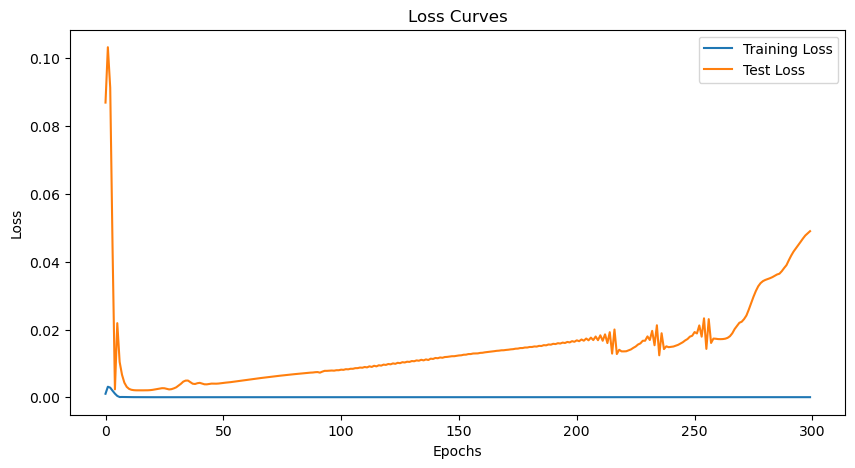

In [13]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0,200)
#plt.ylim(0,0.04)
plt.legend()
plt.show()

With 300 epochs, you will find the model will overfit after ~20 epochs. The test error will explode. This is an indication you should reduce the number of epochs.

Try run the example with 20 epochs to see the results (need to rerun both the Initialize your model code cell and the train model code cell).

Get prediction for both training data and test data to evaluate performance.

In [14]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())
        
        actuals.extend(labels.view(-1).tolist())
        
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())
        
        actuals.extend(labels.view(-1).tolist())

# Optionally, if you normalized your target variable, you should inverse transform the predictions and actuals here
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).reshape(-1)

Plot the predicted price, before the blue line are the training data, and after the blue line is the testing data.

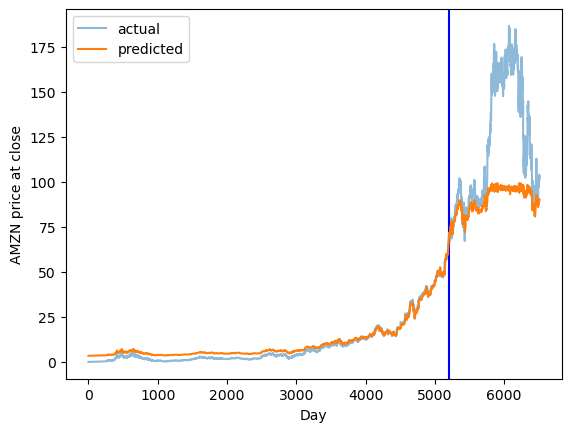

In [15]:
plt.plot(actuals,label="actual",alpha=0.5)
plt.axvline(x = split, color = 'b')
plt.plot(predictions,label="predicted")
plt.xlabel('Day')
plt.ylabel('AMZN price at close')
plt.legend()